# 准备工作

## 导入模块

In [1]:
import os 
import pandas as pd
import numpy as np
import math
import csv
from copy import deepcopy
import datetime
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号 ！！！！！！！！这个部分不用导入新的包，很容易记混，就用plt自带的就行
plt.rcParams['font.sans-serif']=['SimHei']                    
plt.rcParams['axes.unicode_minus']=False

## 导入数据函数

In [3]:
##导入各持有期股价数据
def read_origin_stock_data(origin_stock_path):  #读取太慢可以改成多线程读取
    year_list = []
    for file_name, file_format in [os.path.splitext(dir) for dir in os.listdir(origin_stock_path)]:
        if file_format == '.xlsx':
            year = file_name.strip('_.')
            year_list.append(year)
            one_year_stock_path = os.path.join(origin_stock_path, year + file_format) 
            one_year_stock = pd.read_excel(one_year_stock_path, skiprows = 4)
            list_columns = [ column  for column in one_year_stock.columns if 'Unnamed' in str(column)] 
            globals()['stock_'+year] = one_year_stock.drop(list_columns, axis=1)     ### globals()是什么作用啊？ !!!这个其实目前看来没什么用，就是我想储存一下变量，怕到时候妹妹有什么需求可以及时改，而且声明为全局变量，在哪里都可以用下面有些函数就用到了!
    return list(set(year_list))   ## set(year_list)是什么啊？！！！有时候读取文件时有一些缓存，然后文件名会重复，就是删除一下重复的年份。    

In [4]:
##导入分组持仓数据
def read_stock_group_data(stock_group_path):
    category_list = []
    for file_name, file_format in [os.path.splitext(dir) for dir in os.listdir(stock_group_path)]:
        if file_format == '.csv':
            category = file_name.strip('_.')
            category_list.append(category)
            one_stock_group_path = os.path.join(stock_group_path, category + file_format) 
            one_stock_group = pd.read_csv(one_stock_group_path, index_col = 0, encoding='utf-8')  ###！！！index_col = 0表示设置日期为index！！！！就是当时读文件时有些小bug，好像是big，mid，small三张表多出一行index，要是直接读入就会有两行index，索性将原有的index设置为index，加上这个就好了？
            globals()['group_'+category] = one_stock_group
    return list(set(category_list))

## 数据整理函数

In [5]:
def generate_sequence_stat(category_list, year_list, year_category_63_path, year_asset_stat_path, asset_value_path):
    asset_stat = {}
    for year in year_list:
        asset_stat[year] = {}
        asset_stat[year]['date'] = []
        for category in category_list:
            asset_stat[year][category] =[]
    for year in year_list:
        for category in category_list:
            the_group = eval('group_'+ category)
            the_year_stock = eval('stock_'+year)
            year_category_group = the_group[the_group['最新调整日期'].apply(lambda x: x.split('-')[0]) == year]
            year_category_group_seq = pd.merge(year_category_group, the_year_stock.drop('最新调整日期', axis=1), 
                                               on='Wind代码', how='left')
            globals()['_'.join([year,category,'seq'])] = year_category_group_seq
            fill_the_chart(year, category, year_category_group_seq, asset_stat)
            store_path = os.path.join(year_category_63_path, '_'.join([year,category,'seq'])+'.csv')
            year_category_group_seq.to_csv(store_path, encoding='utf_8_sig', index = False)
            comupute_rate_store(store_path, year_category_group_seq)
    asset_store(asset_stat, year_asset_stat_path, asset_value_path)

            
def comupute_rate_store(store_path, year_category_group_seq):
    date_seq = [column for column in year_category_group_seq.columns 
                if isinstance(column,datetime.datetime)]                  ##？？ ！！！！判断列名是否为日期的实例，如果是日期就收录这个函数经常用就是判断是哪个类的实例
    new_line = ['' for _ in range(len(year_category_group_seq.columns))]
    replace_index_list = []
    last_seq = date_seq[:-1]
    current_seq = date_seq[1:]
    for last_date , current_date in zip(last_seq, current_seq):
        last_amount = np.inner(np.array(year_category_group_seq['pct']),
                               np.array(year_category_group_seq[last_date]))
        current_amount = np.inner(np.array(year_category_group_seq['pct']), 
                                  np.array(year_category_group_seq[current_date]))
        mean_return_rate = np.log(current_amount) - np.log(last_amount)
        replace_index = list(year_category_group_seq.columns).index(current_date)
        new_line[replace_index] = mean_return_rate        #！！！求各期对数收益率，补充到各年各组的表格中
    with open(store_path, 'a', newline='') as f:         ##！！！！这个就是添加哪个总收益率的那一行,向csv中写入操作
        csv_write = csv.writer(f)
        csv_write.writerow(new_line)
        

##哥哥可以解释一下各个函数的意思嘛？！！！！这个函数就是昨天晚上妹妹的要求啊，形成每年各个分类的持股量， 前面我生成了字典，这个就是向字典asset_stat里面填写计算后的数字
def fill_the_chart(year, category, year_category_group_seq, asset_stat):
    date_seq = [column for column in year_category_group_seq.columns if isinstance(column,datetime.datetime)]
    for date_data in date_seq:
        if date_data not in asset_stat[year]['date']:
            asset_stat[year]['date'].append(date_data)
        asset_stat[year][category].append(np.around(np.inner(np.array(year_category_group_seq['pct']), 
                                                             np.array(year_category_group_seq[date_data])), 4))

        ###np.inner为对应相乘再求和？！！！就是内积
        
def asset_store(asset_stat, year_asset_stat_path, asset_value_path): 
    asset_value = pd.DataFrame()
    for year, asset in asset_stat.items():
        year_asset_path = os.path.join(year_asset_stat_path, '_'.join([year,'asset'])+'.csv')
        year_asset_df = pd.DataFrame(asset_stat[year])
        if year != '2020':
            year_asset_df_del = year_asset_df.iloc[:-1,:]     #除了最后一年的表，均删掉最后一行
        else:
            year_asset_df_del = year_asset_df
        asset_value = asset_value.append(year_asset_df_del)     #将统一组合的各年度组合价值汇总
        year_asset_df.to_csv(year_asset_path, encoding='utf_8_sig', index = False)      #分年份生成组合价值表
    asset_value.to_csv(asset_value_path,encoding='utf_8_sig', index = False)     #生成组合价值汇总表

## 开始导入数据

In [6]:
origin_stock_path = './Dataset/Raw/origin_stock'
stock_group_path = './Dataset/Raw/stock_group'
year_category_63_path = './Dataset/Result/Sequence'
year_asset_stat_path = './Dataset/Result/Portfolio_year'
asset_value_path =  './Dataset/Result/Portfolio_all/portfolio_value_all.csv'

In [7]:
year_list = read_origin_stock_data(origin_stock_path)

In [8]:
category_list = read_stock_group_data(stock_group_path)

In [9]:
generate_sequence_stat(category_list, year_list, year_category_63_path, year_asset_stat_path, asset_value_path)

In [21]:
asset_value = pd.read_csv('./Dataset/Result/Portfolio_all/portfolio_value_all.csv')
asset_value.timestamp=pd.to_datetime(asset_value.date,format='%Y-%m-%d')
asset_value.index=asset_value.timestamp        
asset_value = asset_value.sort_index()             #期初行序是乱的，按照日期升序排列！！！妹妹好棒，昨天我也注意到了，但偷懒了
asset_value = asset_value[['small','mid','big']]   #调整行顺序
asset_value

<ipython-input-21-ba84472a4255>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  asset_value.timestamp=pd.to_datetime(asset_value.date,format='%Y-%m-%d')


,small,mid,big
date,,,
2000-05-12,5.9123,4.4818,3.5168
2000-05-19,6.1417,4.6537,3.6598
2000-05-26,6.4536,4.9186,3.8978
2000-06-02,6.4872,4.9441,4.0123
2000-06-09,6.4952,4.9157,3.9739
...,...,...,...
2020-06-05,24.5943,11.3219,6.1759
2020-06-12,24.8061,11.3263,6.1511
2020-06-19,25.6523,11.6216,6.2939


# 回测分析

## 净值曲线

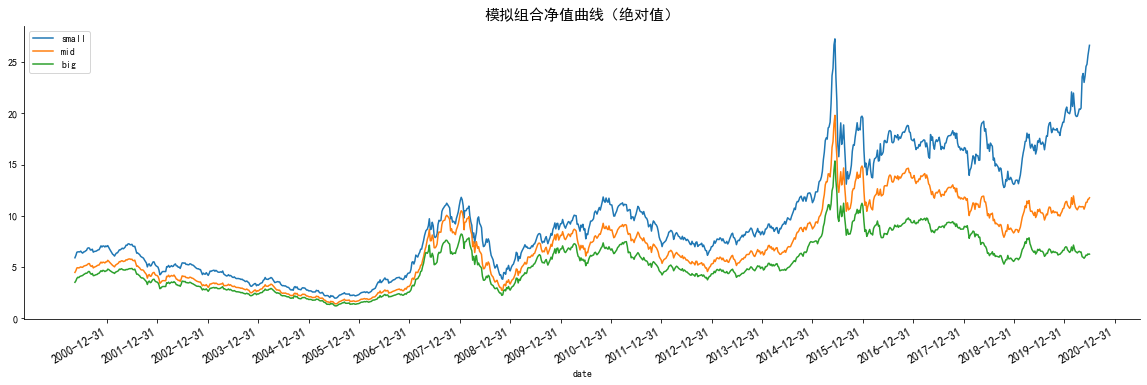

In [99]:
#将回测期间内的净值可视化
all_value.plot(figsize=(20,6))
#图标题
plt.title('模拟组合净值曲线（绝对值）',fontsize=15)
#设置x轴坐标
my_ticks = pd.date_range('2000-05-12','2021-01-01',freq='Y')
plt.xticks(my_ticks,fontsize=12)
# 去掉上和右的图边界线
ax=plt.gca()
ax.spines['right'].set_color('none')             
ax.spines['top'].set_color('none')
plt.show()

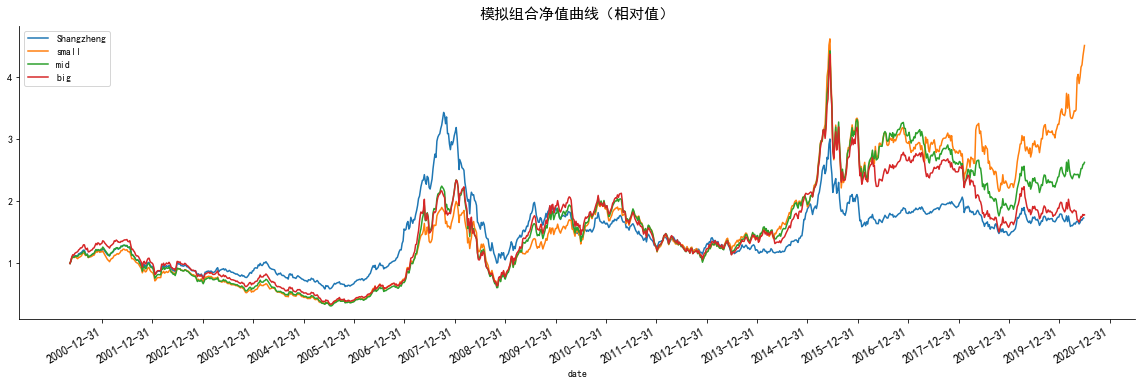

In [124]:
#以第一交易日为基点，计算净值
all_value_new=all_value_new/all_value_new.iloc[0]  ##all_value_new包含指数，下文生成
#将回测期间内的净值可视化
all_value_new.plot(figsize=(20,6))
#图标题
plt.title('模拟组合净值曲线（相对值）',fontsize=15)
# 设置x轴坐标
my_ticks = pd.date_range('2000-05-12','2021-01-01',freq='Y')
plt.xticks(my_ticks,fontsize=12)
# 去掉上和右的图边界线
ax=plt.gca()           
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

## 累计收益率 & 年化收益率

In [85]:
### 区间累计收益率(绝对收益率)
total_ret=asset_value_new.iloc[-1]-1
TR=pd.DataFrame(total_ret.values,columns=['累计收益率'],index=total_ret.index)
TR

,累计收益率
small,3.507654
mid,1.626579
big,0.782444


In [86]:
###年化收益率,假设一年以250交易日计算
annual_ret=pow(1+total_ret,250/len(asset_value_new))-1
AR=pd.DataFrame(annual_ret.values,columns=['年化收益率'],index=annual_ret.index)
AR

,年化收益率
small,0.446379
mid,0.267044
big,0.152188


## 最大回撤

In [87]:
#numpy:np.maximum.accumulate计算序列累计最大值
code='small' #以small为例
n_d=((np.maximum.accumulate(asset_value[code])-asset_value[code])/np.maximum.accumulate(asset_value[code])).max()
#pandas使用cummax（）计算序列累计最大值
p_d=((asset_value[code].cummax()-asset_value[code])/asset_value[code].cummax()).max()
#打印结果
print(f'numpy方法下small组合最大回撤的计算结果：{round(n_d*100,2)}%')
print(f'pandas方法下small组合最大回撤的计算结果：{round(p_d*100,2)}%') 

numpy方法下small组合最大回撤的计算结果：72.85%
pandas方法下small组合最大回撤的计算结果：72.85%


In [88]:
#定义求最大回撤的函数成函数
def max_drawdown(df):
    md=((df.cummax()-df)/df.cummax()).max()
    return round(md,4)
md={}
for name in asset_value.columns:
    md[name]=max_drawdown(asset_value[name])
#最大回撤率结果：
MD=pd.DataFrame(md,index=['最大回撤']).T
MD

,最大回撤
small,0.7285
mid,0.7554
big,0.7512


## beta & alpha


In [112]:
#选取上证综合指数为基准
import tushare as ts
ts.set_token('4920c9b877799be6efcaccc0cf3f726382de233f693dd3b54d360185')
pro = ts.pro_api()
df = pro.index_weekly(ts_code='000001.SH', start_date='20000512', end_date='20200630', 
                      fields='ts_code,trade_date,open,high,low,close,vol,amount')

Exception: 抱歉，您没有访问该接口的权限，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。

In [116]:
df= ts.get_k_data('sh',start='2000-05-12',end='2020-06-30',ktype='W') #默认前复权
df = df.sort_values( by = 'date')
df.timestamp=pd.to_datetime(df.date,format='%Y-%m-%d')
df.index=df.timestamp
df = df.sort_index()
df.index.name = 'date'
SZ_value = pd.DataFrame(df['close'])
SZ_value

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


<ipython-input-116-fe5933642282>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.timestamp=pd.to_datetime(df.date,format='%Y-%m-%d')


,close
date,
2000-05-12,1720.61
2000-05-19,1777.83
2000-05-26,1879.62
2000-06-02,1916.25
2000-06-09,1900.79
...,...
2020-05-29,2852.35
2020-06-05,2930.80
2020-06-12,2919.74


In [117]:
#合并投资组合表和基础指数表
all_value = asset_value.join(SZ_value)        
all_value = all_value.rename(columns={'close':'Shangzheng'})
all_value = all_value[['Shangzheng','small','mid','big']]
all_value

,Shangzheng,small,mid,big
date,,,,
2000-05-12,1720.61,5.9123,4.4818,3.5168
2000-05-19,1777.83,6.1417,4.6537,3.6598
2000-05-26,1879.62,6.4536,4.9186,3.8978
2000-06-02,1916.25,6.4872,4.9441,4.0123
2000-06-09,1900.79,6.4952,4.9157,3.9739
...,...,...,...,...
2020-06-05,2930.80,24.5943,11.3219,6.1759
2020-06-12,2919.74,24.8061,11.3263,6.1511
2020-06-19,2967.63,25.6523,11.6216,6.2939


In [118]:
#计算每日收益率
#收盘价缺失值，使用前值代替
rets=(all_value.fillna(method='pad')).apply(lambda x:x/x.shift(1)-1)[1:]
rets

,Shangzheng,small,mid,big
date,,,,
2000-05-19,0.033256,0.038800,0.038355,0.040662
2000-05-26,0.057255,0.050784,0.056922,0.065031
2000-06-02,0.019488,0.005206,0.005184,0.029376
2000-06-09,-0.008068,0.001233,-0.005744,-0.009571
2000-06-16,0.013757,-0.001909,0.011840,0.027303
...,...,...,...,...
2020-06-05,0.027504,0.040302,0.035808,0.030725
2020-06-12,-0.003774,0.008612,0.000389,-0.004016
2020-06-19,0.016402,0.034113,0.026072,0.023215


In [119]:
#基准收益为x，组合收益为y
from scipy import stats
x=rets.iloc[:,0].values
y=rets.iloc[:,1:].values
AB_reg=pd.DataFrame()
alpha=[]
beta=[]
for i in range(3):
#使用scipy库中的stats.linregress线性回归
#python回归有多种实现方式，
#如statsmodels.api的OLS，sklearn库等等
    b,a,r_value,p_value,std_err=stats.linregress(x,y[:,i])
    alpha.append(round(a*250,3))      #alpha转化为年化
    beta.append(round(b,3))
AB_reg['beta']=beta
AB_reg['alpha']=alpha
AB_reg.index=rets.columns[1:]

AB_reg

,beta,alpha
small,0.986,0.319
mid,1.065,0.165
big,1.062,0.067


In [120]:
#使用公式法直接计算beta值：
beta1=rets[['Shangzheng','small']].cov().iat[0,1]/rets['Shangzheng'].var()
beta2=rets[['Shangzheng','mid']].cov().iat[0,1]/rets['Shangzheng'].var()
beta3=rets[['Shangzheng','big']].cov().iat[0,1]/rets['Shangzheng'].var()
# print(f'small_beta:{round(beta1,3)}')
# print(f'mid_beta:{round(beta2,3)}')
# print(f'big_beta:{round(beta3,3)}')

#使用公式法直接计算alpha值:(由于误差，和第一种方法不一样？)
all_value_new=all_value/all_value.iloc[0]
all_total_ret=(all_value_new.fillna(method='pad')).iloc[-1]-1
all_annual_ret=pow(1+all_total_ret,250/len(all_value_new))-1
alpha1=(all_annual_ret[1]-all_annual_ret[0]*beta1)
alpha2=(all_annual_ret[2]-all_annual_ret[0]*beta2)
alpha3=(all_annual_ret[3]-all_annual_ret[0]*beta3)
# print(f'small_alpha:{round(alpha1,3)}')
# print(f'mid_alpha:{round(alpha2,3)}')
# print(f'big_alpha:{round(alpha3,3)}')

AB_formu=pd.DataFrame({'beta':[round(beta1,3),round(beta2,3),round(beta3,3)],
                        'alpha':[round(alpha1,3),round(alpha2,3),round(alpha3,3)]},index=['small','mid','big'])

AB_formu

,beta,alpha
small,0.986,0.304
mid,1.065,0.114
big,1.062,-0.001


## 夏普比率 & 信息比率

In [121]:
#超额收益率以无风险收益率为基准
#假设无风险收益率为年化3%
exReturn=rets-0.03/250
#计算夏普比率
sharperatio=np.sqrt(len(exReturn))*exReturn.mean()/exReturn.std()
#夏普比率的输出结果
SHR=pd.DataFrame(sharperatio,columns=['夏普比率'])

SHR

,夏普比率
Shangzheng,0.931778
small,1.710854
mid,1.304939
big,1.009828


In [122]:
##信息比率
#超额收益率以指数收益率或其他为基准
#这里以上证综指为基准
ex_return=pd.DataFrame() 
ex_return['mid']=rets.iloc[:,1]-rets.iloc[:,0]
ex_return['small']=rets.iloc[:,2]-rets.iloc[:,0]                  
ex_return['big']=rets.iloc[:,3]-rets.iloc[:,0]

#计算信息比率
information=np.sqrt(len(ex_return))*ex_return.mean()/ex_return.std()
#信息比率的输出结果
INR=pd.DataFrame(information,columns=['信息比率'])

INR  

,信息比率
mid,1.558953
small,1.055588
big,0.498965


## 结果汇总

In [123]:
#将上述指标合并成一张表
indicators=pd.concat([TR,AR,MD,AB,SHR,INR],axis=1,join='inner',sort='False')
#结果保留三位小数
indicators.round(3)

,累计收益率,年化收益率,最大回撤,alpha,beta,夏普比率,信息比率
big,0.782,0.152,0.751,0.096,0.374,1.010,0.499
mid,1.627,0.267,0.755,0.208,0.354,1.305,1.559
small,3.508,0.446,0.728,0.378,0.300,1.711,1.056
